In [17]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional, List
import matplotlib.pyplot as plt

In [18]:
DATA_ROOT = Path("data")

TRENDS_DATA = DATA_ROOT / "google_trends"
STOCKS_DATA = DATA_ROOT / "market"
PROCESSED_DATA = DATA_ROOT / "processed"

In [19]:
def safe_read_csv(file_path)->Optional[pd.DataFrame]:
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            # logging.warning(f"DataFrame from {file_path} is empty.")
            return None
        return df
    except Exception as e:
        # logging.warning(f"Error reading {file_path}: {e}")
        return None

In [20]:
stocks_dfs: List[pd.DataFrame] = []
trends_dfs: List[pd.Series] = []

for f in STOCKS_DATA.glob("*.csv"):
    df = safe_read_csv(f)
    if df is not None:
        stocks_dfs.append(df)
        
for f in TRENDS_DATA.glob("*.csv"):
    df = safe_read_csv(f)
    if df is not None:
        df.set_index('date', inplace=True)
        trends_dfs.append(df.iloc[:, 0])


assert all(df is not None for df in stocks_dfs), "Some stock DataFrames failed to load"
assert all(df is not None for df in trends_dfs), "Some trends DataFrames failed to load"

num_stocks_files = len(list(STOCKS_DATA.glob("*.csv")))
num_trends_files = len(list(TRENDS_DATA.glob("*.csv")))

print(f"Loaded {len(stocks_dfs)}/{num_stocks_files} stock data files.")
print(f"Loaded {len(trends_dfs)}/{num_trends_files} trends data files.")

Loaded 103/103 stock data files.
Loaded 2409/3003 trends data files.


In [21]:
def parse_stock_field(df:pd.DataFrame, field:str)->Optional[pd.Series]:
    # Check if the field exists in the DataFrame
    if field in df.columns:
        df_ = df.set_index('Price')
        df_ = df_[field].iloc[2:]
        df_.index.name='date'
        df_.name = df.iloc[0][field]
        return df_
    else:
        return None

In [22]:
stocks_shapes = pd.Series({df.iloc[0, 1]: df.shape[0] for df in stocks_dfs}).astype(int)
common_length = stocks_shapes.value_counts().index[0]

reg_stocks_dfs = [df for df in stocks_dfs if df.shape[0] == common_length]
# remove duplicates from list
reg_stocks_dfs = list({df.iloc[0, 1]: df for df in reg_stocks_dfs}.values())

volume_dfs: List[pd.Series] = []
price_dfs: List[pd.Series] = []

for df in reg_stocks_dfs:
    
    volume_sr = parse_stock_field(df, 'Volume')
    if volume_sr is not None:
        volume_dfs.append(volume_sr)
        
    price_sr = parse_stock_field(df, 'Close')
    if price_sr is not None:
        price_dfs.append(price_sr)

In [23]:
trends_dfs_shapes = pd.Series({df.name: df.shape for df in trends_dfs})
print(trends_dfs_shapes.value_counts())

price_dfs_shapes = pd.Series({s.name: s.shape for s in price_dfs})
print(price_dfs_shapes.value_counts())

volume_dfs_shapes = pd.Series({s.name: s.shape for s in volume_dfs})
print(volume_dfs_shapes.value_counts())

(261,)    2409
Name: count, dtype: int64
(1256,)    75
Name: count, dtype: int64
(1256,)    75
Name: count, dtype: int64


In [24]:
trends_variaty = pd.Series({s.name: len(np.nonzero(s)[0]) for s in trends_dfs})
trends_variaty.value_counts().head(10)
# trends_variaty.hist(bins=30)

1      617
261    608
2      293
3      149
4       55
5       38
6       28
8       25
11      19
10      19
Name: count, dtype: int64

In [25]:
interesting_trends_list: List[pd.Series] = []
for trend in trends_dfs:
    if len(np.nonzero(trend)[0])>1:
        interesting_trends_list.append(trend)

print(f'Found {len(interesting_trends_list)}/{len(trends_dfs)} interesting trends out of all trends.')

Found 1792/2409 interesting trends out of all trends.


In [26]:
volumes_raw = pd.concat(volume_dfs, axis=1).astype(float)
prices_raw = pd.concat(price_dfs, axis=1).astype(float)
trends_raw = pd.concat(interesting_trends_list, axis=1).astype(float)

In [27]:
def interpolate_values_by_date(df:pd.DataFrame)->pd.DataFrame:
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    df_daily = df.resample('D').asfreq()
    df_daily = df_daily.interpolate(method='linear')
    return df_daily

In [28]:
trends = interpolate_values_by_date(trends_raw)
prices = interpolate_values_by_date(prices_raw)
volumes = interpolate_values_by_date(volumes_raw)

index_intersection = trends.index.intersection(prices.index).intersection(volumes.index)
index_intersection.shape

trends=trends.loc[index_intersection]
prices=prices.loc[index_intersection]
volumes=volumes.loc[index_intersection]

assert trends.index.equals(prices.index) and prices.index.equals(volumes.index), "Indexes do not match after alignment"
trends.shape, prices.shape, volumes.shape

((1796, 1792), (1796, 75), (1796, 75))

<Axes: title={'center': 'fintech trends'}, xlabel='date'>

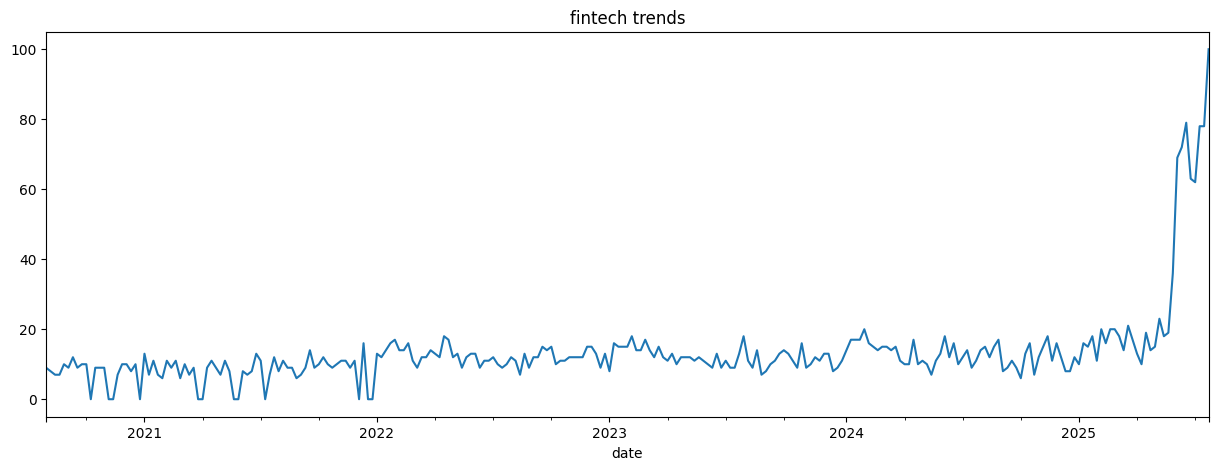

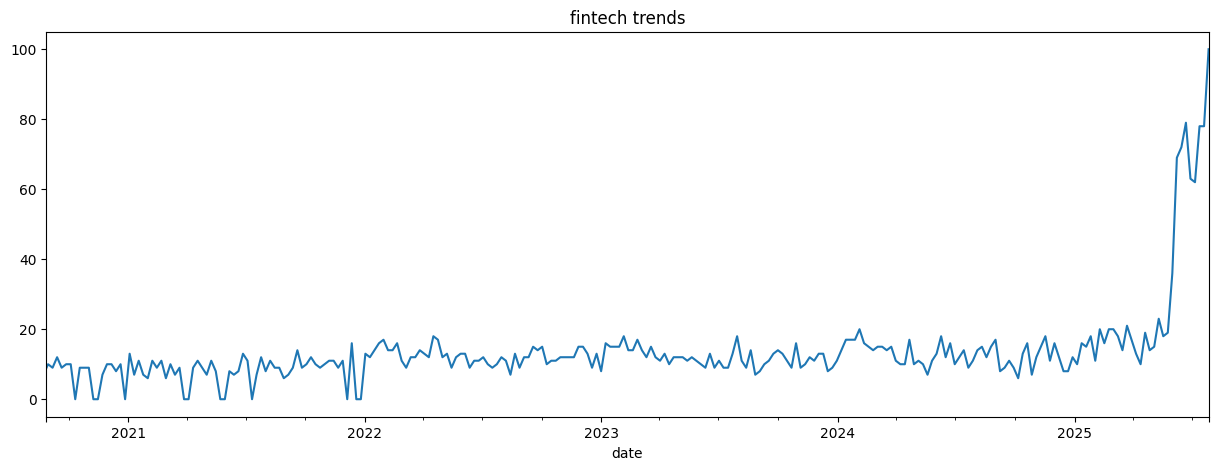

In [29]:
plt.figure()
trends_raw.iloc[:,0].plot(legend=False, figsize=(15,5), title=trends_raw.columns[0])
plt.figure()
trends.iloc[:,0].plot(legend=False, figsize=(15,5), title=trends_raw.columns[0])

In [30]:
trends.to_csv(PROCESSED_DATA / "trends.csv")
prices.to_csv(PROCESSED_DATA / "prices.csv")
volumes.to_csv(PROCESSED_DATA / "volumes.csv")